In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import netCDF4 as nc
import scipy.io as sio
from datetime import datetime
from datetime import datetime, timedelta

import sys
sys.path.append("/home/z5297792/UNSW-MRes/MRes/modules")
from utils import obs_moca, espra, smooth, tilt_distance_LI, robust_smooth, axis_ratio
from utils import normalize_matrix, calc_ow, fit_psi_params, psi_params
from utils import project_sadcp_to_transect, translate_moca_results


### Satellite Data

In [2]:
ssh_path = '/srv/scratch/z5297792/ESP_Paper_Data/sat_data_IMOS_drifters.nc'
ssh_dataset = nc.Dataset(ssh_path, mode='r')

lon_ssh, lat_ssh = ssh_dataset['LONGITUDE'][:].data, ssh_dataset['LATITUDE'][:].data
lon_ssh, lat_ssh = np.meshgrid(lon_ssh, lat_ssh)
u_ssh, v_ssh = ssh_dataset['UCUR'][:].data, ssh_dataset['VCUR'][:].data # TIME, LATITUDE, LONGITUDE
u_ssh, v_ssh = np.transpose(u_ssh, axes=(2,1,0)), np.transpose(v_ssh, axes=(2,1,0)) # LON, LAT, TIME
tim_ssh = ssh_dataset['TIME'][:].data # days since 1985-01-01 00:00:00 UTC

ref_date = pd.Timestamp("1985-01-01 00:00:00")
tim_ssh = ref_date + pd.to_timedelta(tim_ssh, unit="D")

dic_ssh_data = {}
for t, time in enumerate(tim_ssh):
    ut, vt = u_ssh[:,:,t].T, v_ssh[:,:,t].T
    ut = np.where(np.abs(ut) < 4.9, ut, np.nan)
    vt = np.where(np.abs(vt) < 4.9, vt, np.nan)
    dic_ssh_data[time] = {'u': ut, 'v': vt}

theta_mean, phi_mean = np.float64(154.3), np.float64(-37.9)
x_ssh = (lon_ssh - theta_mean) * 111000 * np.cos(np.deg2rad(phi_mean))
y_ssh = (lat_ssh - phi_mean) * 111000


### SADCP Data

In [3]:
sadcp_data = sio.loadmat('/srv/scratch/z5297792/ESP_Paper_Data/sadcp_data_CCE_2023.mat', simplify_cells=True)

z_sadcp = sadcp_data['z_sadcp']
u_sadcp = pd.DataFrame(sadcp_data['u_sadcp'], index=['u_' + str(z) for z in z_sadcp]).T
v_sadcp = pd.DataFrame(sadcp_data['v_sadcp'], index=['v_' + str(z) for z in z_sadcp]).T
lat_sadcp = sadcp_data['lat_sadcp']
lon_sadcp = sadcp_data['lon_sadcp']
tim_sadcp = sadcp_data['tim_sadcp']
julian_dates = tim_sadcp
ref_date = datetime(2000, 1, 1, 12)  # Julian day 2451545.0
gregorian_dates = [ref_date + timedelta(days=jd - 2451545.0) for jd in julian_dates]
tim_sadcp = gregorian_dates

df_sadcp = pd.DataFrame({'Time': tim_sadcp, 'Lon': lon_sadcp, 'Lat': lat_sadcp})
df_sadcp = pd.concat([df_sadcp, u_sadcp, v_sadcp], axis=1)

df_sadcp = df_sadcp[df_sadcp['Lat'] <= -37]
df_sadcp = df_sadcp.reset_index().drop(columns=['index'])

theta_mean, phi_mean = np.float64(154.3), np.float64(-37.9)
df_sadcp['x'] = (df_sadcp.Lon - theta_mean) * 111000 * np.cos(np.deg2rad(phi_mean))
df_sadcp['y'] = (df_sadcp.Lat - phi_mean) * 111000

df_sadcp


,Time,Lon,Lat,u_27,u_37,u_47,u_57,u_67,u_77,u_87,...,v_737,v_747,v_757,v_767,v_777,v_787,v_797,v_807,x,y
0,2023-10-17 10:27:31.000004,154.357059,-37.005208,NaN,0.534412,0.569007,0.549270,0.465635,0.374654,0.323217,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4997.725425,99321.875000
1,2023-10-17 10:42:30.333327,154.360804,-37.038123,NaN,0.533096,0.555601,0.561888,0.484809,0.402146,0.357385,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5325.695073,95668.330556
2,2023-10-17 10:57:30.666685,154.364625,-37.071899,NaN,0.431565,0.456292,0.483472,0.458337,0.434674,0.398060,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5660.396047,91919.202778
3,2023-10-17 11:12:30.333340,154.368274,-37.101418,NaN,0.368063,0.378524,0.410269,0.398222,0.362505,0.358032,...,0.043708,0.042462,NaN,NaN,NaN,NaN,NaN,NaN,5980.012364,88642.647222
4,2023-10-17 11:27:30.666659,154.372221,-37.104340,NaN,0.357789,0.368125,0.399916,0.385093,0.353109,0.356878,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6325.742980,88318.280556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
428,2023-10-21 21:27:30.333314,154.179344,-37.150309,NaN,0.246921,0.241454,0.244281,0.212926,0.202732,0.233854,...,0.080013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-10568.100129,83215.672222
429,2023-10-21 21:42:30.666672,154.179347,-37.119931,NaN,0.222701,0.196322,0.206364,0.223129,0.236286,0.265476,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-10567.775728,86587.708333
430,2023-10-21 21:57:30.333327,154.179332,-37.088953,NaN,0.214721,0.206698,0.228885,0.243320,0.250907,0.249915,...,0.085535,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-10569.073333,90026.241667
431,2023-10-21 22:12:30.333314,154.179352,-37.058304,NaN,0.219740,0.226015,0.243559,0.245731,0.227310,0.231003,...,0.077085,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-10567.370226,93428.288889


In [6]:
def plotter(
    t0=pd.Timestamp("2023-10-20 12:00:00"),
    dt=pd.Timedelta(days=0.3),
    gap=70,
    z=37,
    L_km=200,
    nL=101,
    sp=1,
    scale=15,
):
    m = df_sadcp.Time.between(t0 - dt, t0 + dt)
    dft = df_sadcp.loc[m]

    xi, yi = dft.x.values, dft.y.values
    ui, vi = dft[f"u_{z}"].values, dft[f"v_{z}"].values

    df_proj, moca_meta = project_sadcp_to_transect(xi, yi, ui, vi)
    l0, r0, w, Q, Rc, psi0, A = obs_moca(df_proj.l, df_proj.V_T, df_proj.V_N, plot_flag=True)
    xc, yc = translate_moca_results(df_proj.iloc[0].x, df_proj.iloc[0].y, moca_meta, l0, r0)

    L = np.linspace(-L_km * 1e3, L_km * 1e3, nL)
    X, Y = np.meshgrid(L, L, indexing="ij")

    def rho2_field(Q_, dx_, dy_):
        return Q_[0, 0] * dx_**2 + 2 * Q_[1, 0] * dx_ * dy_ + Q_[1, 1] * dy_**2

    def plot_core(ax, Q_, Rc_, xc_, yc_, color, lw=2):
        dx = X / 1e3 - xc_ / 1e3
        dy = Y / 1e3 - yc_ / 1e3
        rho2 = rho2_field(Q_, dx, dy)
        ax.contour(X / 1e3, Y / 1e3, rho2, levels=[(Rc_ / 1e3) ** 2 / 2], colors=color, linewidths=lw)

    def set_box(ax):
        ax.axis("equal")
        ax.set_xlim(L.min() / 1e3 + gap, L.max() / 1e3 - gap)
        ax.set_ylim(L.min() / 1e3 + gap, L.max() / 1e3 - gap)
        ax.set_xlabel("x (km)")
        ax.set_ylabel("y (km)")

    def recon_velocity(Q_, Rc_, A_, dx_, dy_):
        rho2 = rho2_field(Q_, dx_, dy_)
        fac = A_ * np.exp(-rho2 / Rc_**2)
        u = -fac * (2 * Q_[1, 0] * dx_ + 2 * Q_[1, 1] * dy_)
        v =  fac * (2 * Q_[0, 0] * dx_ + 2 * Q_[1, 0] * dy_)
        return u, v

    # --- Transect view ---
    fig, ax = plt.subplots()
    ax.quiver(df_proj.l / 1e3, np.zeros(len(df_proj)), df_proj.V_T, df_proj.V_N)
    ax.scatter(l0 / 1e3, r0 / 1e3)
    dx = X / 1e3 - l0 / 1e3
    dy = Y / 1e3 - r0 / 1e3
    rho2 = rho2_field(Q, dx, dy)
    ax.contour(X / 1e3, Y / 1e3, rho2, levels=[(Rc / 1e3) ** 2 / 2], colors="r")
    ax.set(xlim=(-10, 150), ylim=(-50, 50), aspect="equal")

    # --- SSH snapshot closest in time ---
    t_closest = min(tim_ssh, key=lambda t: abs(t - t0))
    ut, vt = dic_ssh_data[t_closest]["u"], dic_ssh_data[t_closest]["v"]
    speed = np.hypot(ut, vt)

    fig, axs = plt.subplots(1, 3, figsize=(14, 5))

    cb0 = axs[0].contourf(x_ssh / 1e3, y_ssh / 1e3, speed, cmap="Blues_r", levels=np.linspace(0, 0.9, 7))
    fig.colorbar(cb0, ax=axs[0], location="top")
    axs[0].quiver(x_ssh[::sp, ::sp] / 1e3, y_ssh[::sp, ::sp] / 1e3, ut[::sp, ::sp], vt[::sp, ::sp],
                  width=0.002, scale=scale, color="w")
    axs[0].quiver(xi / 1e3, yi / 1e3, ui, vi, scale=scale, width=0.002)
    axs[1].quiver(xi / 1e3, yi / 1e3, ui, vi, scale=scale, width=0.002, zorder=2)

    for a in axs:
        a.scatter(xc / 1e3, yc / 1e3, c="r", s=100, marker="x", zorder=5)
        plot_core(a, Q, Rc, xc, yc, color="r", lw=2)

    set_box(axs[0])

    # # --- ESPRA overlay (panel 0) ---
    # xc_e, yc_e, w_e, Q_e, Rc_e, psi0_e, A_e = espra(xi, yi, ui, vi)
    # axs[0].scatter(xc_e / 1e3, yc_e / 1e3, c="y", s=100, marker="x", zorder=5)
    # plot_core(axs[0], Q_e, Rc_e, xc_e, yc_e, color="y", lw=2)

    # --- Reconstruction (panel 1) ---
    dx_lr = x_ssh - xc
    dy_lr = y_ssh - yc
    u_lr, v_lr = recon_velocity(Q, Rc, A, dx_lr, dy_lr)

    dx_hr = X - xc
    dy_hr = Y - yc
    u_hr, v_hr = recon_velocity(Q, Rc, A, dx_hr, dy_hr)

    spd_hr = np.hypot(u_hr, v_hr)
    cb1 = axs[1].contourf(X / 1e3, Y / 1e3, spd_hr, cmap="Blues_r", levels=np.linspace(0, 0.9, 7))
    fig.colorbar(cb1, ax=axs[1], location="top")
    axs[1].quiver(x_ssh[::sp, ::sp] / 1e3, y_ssh[::sp, ::sp] / 1e3, u_lr[::sp, ::sp], v_lr[::sp, ::sp],
                  width=0.002, scale=scale, color="w")
    set_box(axs[1])

    # --- SMAPE (panel 2) ---
    E_mag = np.hypot(ut - u_lr, vt - v_lr)
    mag1 = speed
    mag2 = np.hypot(u_lr, v_lr)
    SM_vec = 100.0 * E_mag / (0.5 * (mag1 + mag2) + 1e-6)

    cb2 = axs[2].contourf(x_ssh / 1e3, y_ssh / 1e3, SM_vec, cmap="Greys", levels=np.linspace(0, 200, 9))
    fig.colorbar(cb2, ax=axs[2], location="top")
    set_box(axs[2])

    plt.tight_layout()


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


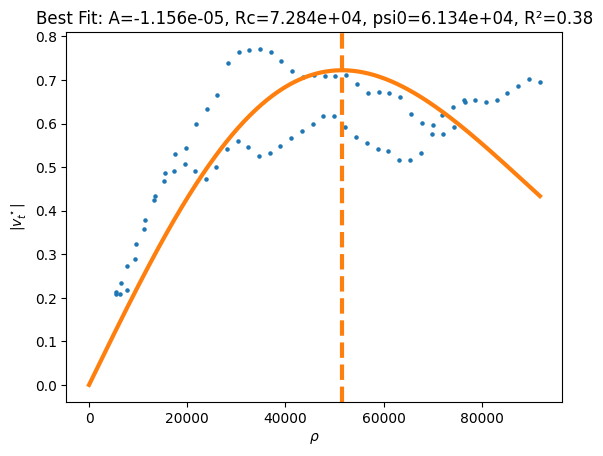

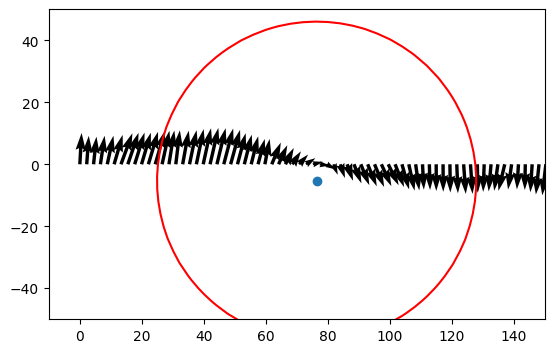

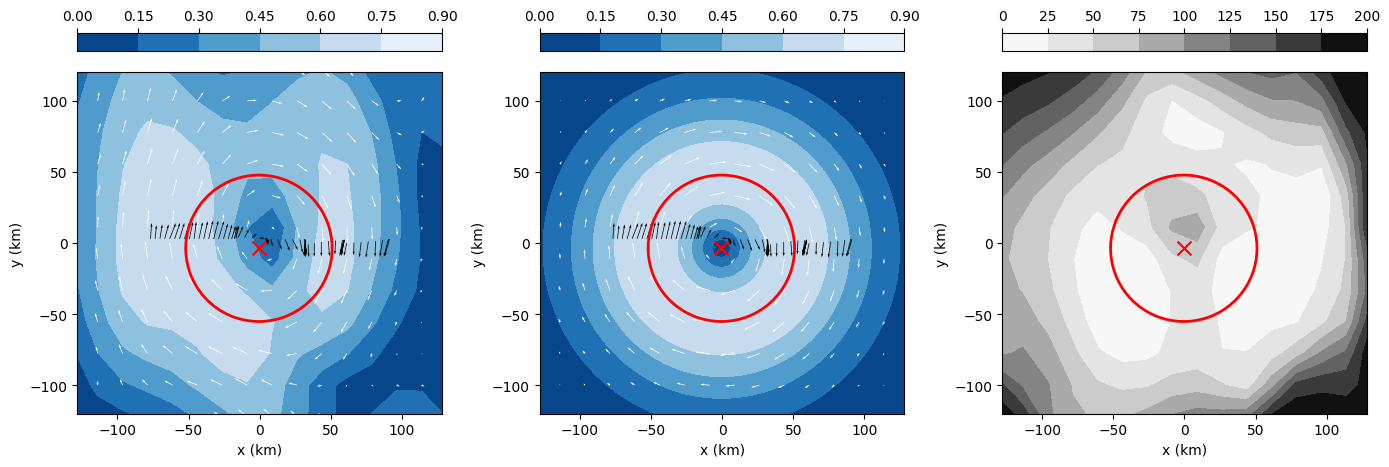

In [7]:
plotter(gap=80, dt=pd.Timedelta(days=.4), t0=pd.Timestamp('2023-10-20 13:00:00'))


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


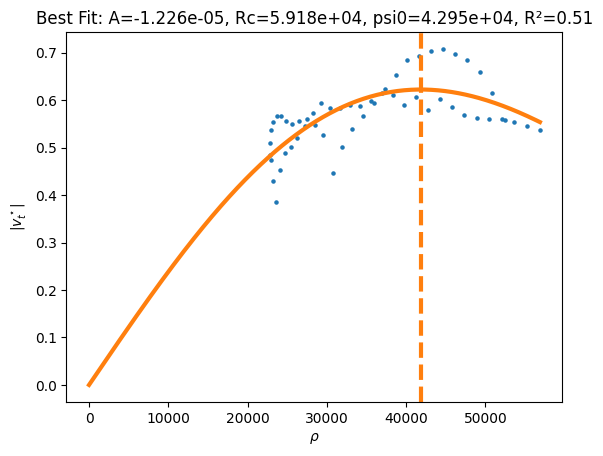

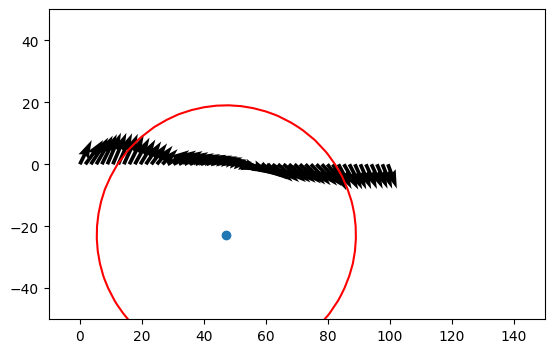

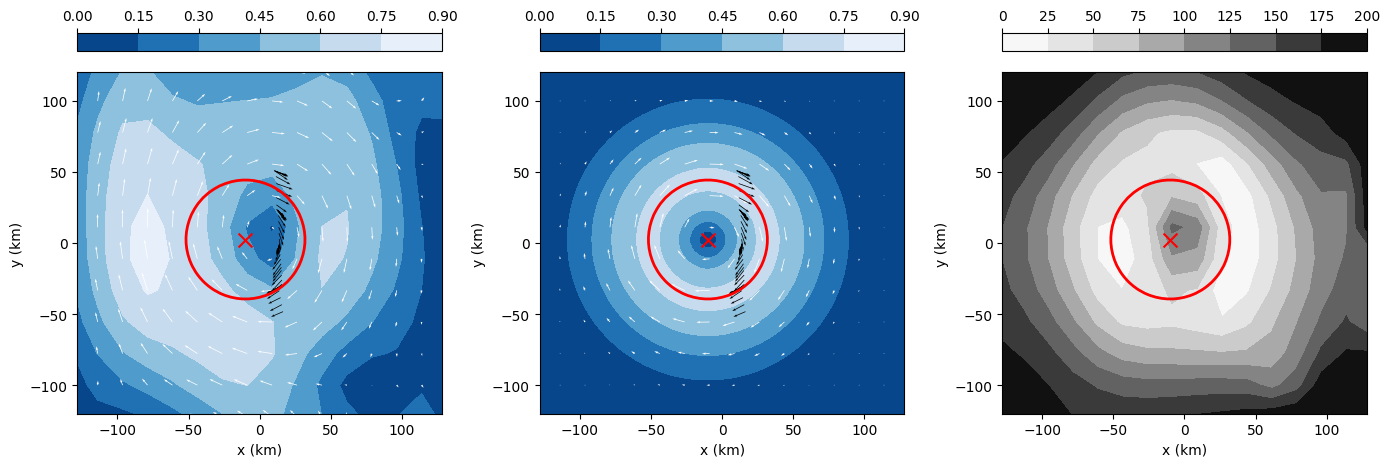

In [10]:
plotter(gap=80, dt=pd.Timedelta(days=.3), t0=pd.Timestamp('2023-10-18 01:00:00'))


In [35]:
def plot_moca_ssh(
    t0=pd.Timestamp("2023-10-20 13:00:00"),
    dt=pd.Timedelta(days=0.4),
    z=37,
    L_km=200,
    nL=101,
    gap=120,
    sp=1,
    scale=15,
    cmap="Blues_r",
    width=0.002,
    lw=2,
    eps=1e-6,
    pad_km=50,
    n_rho=501,
    espra_flag=False
):
    m = df_sadcp.Time.between(t0 - dt, t0 + dt)
    print(t0 - dt, t0 + dt)
    dft = df_sadcp.loc[m]
    xi, yi = dft.x.values, dft.y.values
    ui, vi = dft[f"u_{z}"].values, dft[f"v_{z}"].values

    df_proj, moca_meta = project_sadcp_to_transect(xi, yi, ui, vi)
    l0, r0, w, Q, Rc, psi0, A, df = obs_moca(
        df_proj.l, df_proj.V_T, df_proj.V_N, plot_flag=False, df_flag=True
    )
    xc, yc = translate_moca_results(df_proj.iloc[0].x, df_proj.iloc[0].y, moca_meta, l0, r0)

    print(f'xc:{xc}, yc:{yc}, w:{w}, Rc:{Rc}, psi0:{psi0}, A:{A}')
    
    # fit Rc, psi0, A
    df = psi_params(xc, yc, Q, xi, yi, ui, vi) # input data into m
    if A < 0:
        mask = df.vt <= 0
    else:
        mask = df.vt >= 0
    rho2, Qr, vt = df.rho2[mask], df.Qr[mask], df.vt[mask]

    Rc, psi0, A = fit_psi_params(rho2, Qr, vt, A0=A, Rc_max=200000)

    # plotting window (km)
    xlim = (xc / 1e3 - gap, xc / 1e3 + gap)
    ylim = (yc / 1e3 - gap, yc / 1e3 + gap)

    # mask on SSH grid
    mask = (
        (x_ssh / 1e3 >= xlim[0] - pad_km) & (x_ssh / 1e3 <= xlim[1] + pad_km) &
        (y_ssh / 1e3 >= ylim[0] - pad_km) & (y_ssh / 1e3 <= ylim[1] + pad_km)
    )

    t_closest = min(tim_ssh, key=lambda t: abs(t - t0))
    print(t_closest)
    ut, vt = dic_ssh_data[t_closest]["u"], dic_ssh_data[t_closest]["v"]

    ut_mask = np.where(mask, ut, np.nan)
    vt_mask = np.where(mask, vt, np.nan)
    spd_obs = np.hypot(ut_mask, vt_mask)

    def rho2(Q_, dx_, dy_):
        return Q_[0, 0] * dx_**2 + 2 * Q_[1, 0] * dx_ * dy_ + Q_[1, 1] * dy_**2

    def recon(Q_, Rc_, A_, dx_, dy_):
        r2 = rho2(Q_, dx_, dy_)
        fac = A_ * np.exp(-r2 / Rc_**2)
        u = -fac * (2 * Q_[1, 0] * dx_ + 2 * Q_[1, 1] * dy_)
        v =  fac * (2 * Q_[0, 0] * dx_ + 2 * Q_[1, 0] * dy_)
        return u, v

    # ----- ellipse grid (km) ALWAYS n_rho x n_rho -----
    L = np.linspace(-L_km * 1e3, L_km * 1e3, nL)
    X, Y = np.meshgrid(L, L, indexing="ij")

    x_rho = np.linspace(X.min(), X.max(), n_rho)
    y_rho = np.linspace(Y.min(), Y.max(), n_rho)
    X_rho, Y_rho = np.meshgrid(x_rho, y_rho, indexing="ij")

    dx_ell_km = X_rho / 1e3 - xc / 1e3
    dy_ell_km = Y_rho / 1e3 - yc / 1e3
    rho2_ell = rho2(Q, dx_ell_km, dy_ell_km)

    # ----- reconstruction on SSH grid (meters) -----
    dx_lr_m = x_ssh - xc
    dy_lr_m = y_ssh - yc
    u_lr, v_lr = recon(Q, Rc, A, dx_lr_m, dy_lr_m)
    dx_hr_m = X_rho - xc
    dy_hr_m = Y_rho - yc
    u_hr, v_hr = recon(Q, Rc, A, dx_hr_m, dy_hr_m)
    spd_rec = np.hypot(u_hr, v_hr)

    # make colour scale comparable (your hack)
    spd_rec = spd_rec.copy()
    spd_rec[0, 0] = np.nanmax(spd_obs)

    # ----- SMAPE on SSH grid -----
    E_mag = np.hypot(u_lr - ut_mask, v_lr - vt_mask)
    mag1 = np.hypot(ut_mask, vt_mask)
    mag2 = np.hypot(u_lr, v_lr)
    SM_vec = 100 * E_mag / (0.5 * (mag1 + mag2) + eps)

    fig, axs = plt.subplots(2, 2, figsize=(10, 10))

    # (a) observed
    ax = axs[0, 0]
    cf = ax.contourf(x_ssh / 1e3, y_ssh / 1e3, spd_obs, cmap=cmap)
    ax.quiver(
        x_ssh[::sp, ::sp] / 1e3, y_ssh[::sp, ::sp] / 1e3,
        ut_mask[::sp, ::sp], vt_mask[::sp, ::sp],
        width=width, scale=scale, color="w"
    )
    # --- ESPRA overlay (panel 0) ------
    if espra_flag:
        xc_e, yc_e, w_e, Q_e, Rc_e, psi0_e, A_e = espra(xi, yi, ui, vi)
        ax.scatter(xc_e / 1e3, yc_e / 1e3, c="purple", s=100, marker="x", zorder=4, label='ESPRA')
        dx_ell_km_e = X_rho / 1e3 - xc_e / 1e3
        dy_ell_km_e = Y_rho / 1e3 - yc_e / 1e3
        rho2_ell_e = rho2(Q_e, dx_ell_km_e, dy_ell_km_e)
        ax.contour(X_rho / 1e3, Y_rho / 1e3, rho2_ell_e, levels=[(Rc_e / 1e3) ** 2 / 2], colors="purple", linewidths=lw)
    # ----------------------------------
    ax.quiver(xi / 1e3, yi / 1e3, ui, vi, scale=scale, width=width)
    ax.contour(X_rho / 1e3, Y_rho / 1e3, rho2_ell, levels=[(Rc / 1e3) ** 2 / 2], colors="r", linewidths=lw)
    ax.scatter(xc / 1e3, yc / 1e3, c="r", marker="x", s=75, zorder=5, label='MOCA')
    ax.set_aspect("equal"); ax.set_xlim(*xlim); ax.set_ylim(*ylim)
    cbar1 = fig.colorbar(cf, ax=ax, location="top")
    cbar1.set_label(r'Current Speed [ms$^{-1}$]')
    ax.text(-0.2, 1.28, "a)", transform=ax.transAxes, fontsize=13, fontweight="bold", va="top", ha="left")
    # ax.legend(loc='lower left')

    # (b) reconstructed
    ax = axs[0, 1]
    cf = ax.contourf(X_rho / 1e3, Y_rho / 1e3, spd_rec, cmap=cmap)
    ax.quiver(
        x_ssh[::sp, ::sp] / 1e3, y_ssh[::sp, ::sp] / 1e3,
        u_lr[::sp, ::sp], v_lr[::sp, ::sp],
        width=width, scale=scale, color="w"
    )
    ax.quiver(xi / 1e3, yi / 1e3, ui, vi, scale=scale, width=width)
    ax.contour(X_rho / 1e3, Y_rho / 1e3, rho2_ell, levels=[(Rc / 1e3) ** 2 / 2], colors="r", linewidths=lw)
    ax.scatter(xc / 1e3, yc / 1e3, c="r", marker="x", s=75)
    ax.set_aspect("equal"); ax.set_xlim(*xlim); ax.set_ylim(*ylim)
    cbar2 = fig.colorbar(cf, ax=ax, location="top")
    cbar2.set_label(r'Current Speed [ms$^{-1}$]')
    ax.text(-0.2, 1.28, "b)", transform=ax.transAxes, fontsize=13, fontweight="bold", va="top", ha="left")

    # (c) SMAPE
    ax = axs[1, 0]
    cf = ax.contourf(x_ssh / 1e3, y_ssh / 1e3, SM_vec, cmap="Greys", levels=np.linspace(0, 200, 9))
    ax.contour(X_rho / 1e3, Y_rho / 1e3, rho2_ell, levels=[(Rc / 1e3) ** 2 / 2], colors="r", linewidths=lw)
    ax.scatter(xc / 1e3, yc / 1e3, c="r", marker="x", s=75)
    ax.set_aspect("equal"); ax.set_xlim(*xlim); ax.set_ylim(*ylim)
    cbar3 = fig.colorbar(cf, ax=ax, location="top")
    cbar3.set_label(r'Error [%]')
    ax.text(-0.2, 1.28, "c)", transform=ax.transAxes, fontsize=13, fontweight="bold", va="top", ha="left")

    # (d) VT fit
    ax = axs[1, 1]
    fit_psi_params(df.rho2 / 1e6, df.Qr / 1e3, df.vt, r2_flag=True, plot=True, Rc_max=1e6, ax=ax)
    ax.set_title("")
    ax.text(-0.1, 1.05, "d)", transform=ax.transAxes, fontsize=13, fontweight="bold", va="top", ha="left")
    ax.set_xlabel(r'$\rho$ (km)')
    ax.set_ylabel(r'$|v_t^\star|$ (ms$^{-1}$)')

    for ax in axs.flatten()[:-1]:
        ax.set_xlabel('x (km)'); ax.set_ylabel('y (km)')

    plt.tight_layout()
    plt.show()


2023-10-20 03:54:00 2023-10-20 23:06:00
xc:-447.2886034348194, yc:-3654.508390572785, w:-6.341066902937559e-05, Rc:72849.76277924205, psi0:61313.9524233862, A:-1.1553219609573705e-05
2023-10-20 18:00:00


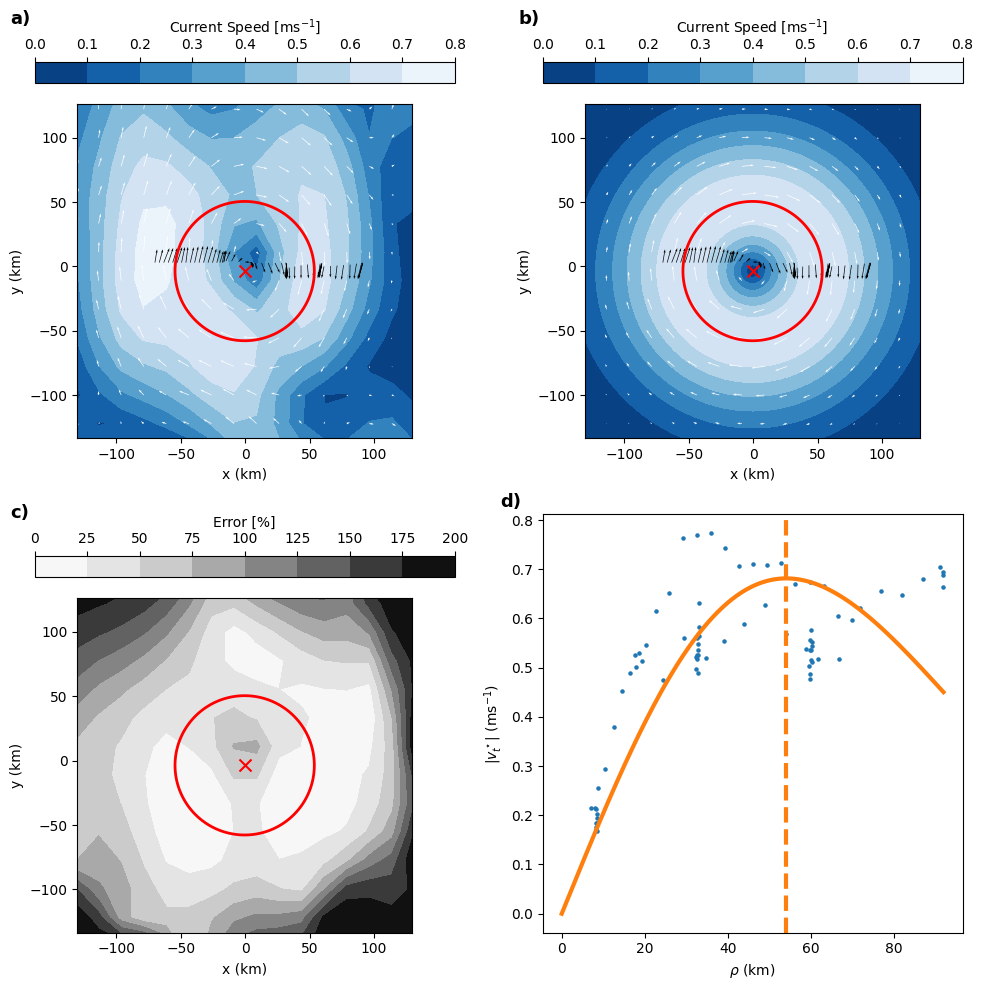

In [36]:
plot_moca_ssh(t0=pd.Timestamp("2023-10-20 13:30:00"), 
              dt=pd.Timedelta(days=0.4), 
              gap=130, espra_flag=False)
